<a href="https://colab.research.google.com/github/Chhavi007/MajorProject_Anomaly-Detection-in-Weather-Data-Using-LSTM-Autoencoder/blob/main/LSTMmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing the required libraries
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [ ]:
# Mounting the drive and loading the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Reading the train data
data= pd.read_csv('/content/drive/MyDrive/lstm/DailyDelhiClimateTrain.csv')
print(data.shape)
data.head()

(1462, 5)


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
# Reading the test data
data2= pd.read_csv('/content/drive/MyDrive/lstm/DailyDelhiClimateTest.csv')
print(data2.shape)
data2.head()

(114, 5)


,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [ ]:
# Combining the Test and Train datasets
data = pd.concat([data, data2])
print(data.shape)
data.head()

(1576, 5)


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
# Extracting date and meantemp from data
df = data[['date', 'meantemp']]
print(df.shape)
df.head()

(1576, 2)


,date,meantemp
0,2013-01-01,10.000000
1,2013-01-02,7.400000
2,2013-01-03,7.166667
3,2013-01-04,8.666667
4,2013-01-05,6.000000


In [ ]:
# Concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1576 entries, 0 to 113
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      1576 non-null   object 
 1   meantemp  1576 non-null   float64
dtypes: float64(1), object(1)
memory usage: 36.9+ KB


In [ ]:
df['date'].min(), df['date'].max()

('2013-01-01', '2017-04-24')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'], y=df['meantemp'], name='meantemp'))
fig.update_layout(showlegend=True, title='Time series graph of temperature')
fig.show()

In [ ]:
#TEST-TRAIN split

train = df.loc[df['date'] <= '2016-06-24']
test = df.loc[df['date'] > '2016-06-24']
train.shape, test.shape


((1271, 2), (305, 2))

Data Scaling

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['meantemp']).reshape(-1,1))

train['meantemp'] = scaler.transform(np.array(train['meantemp']).reshape(-1,1))
test['meantemp'] = scaler.transform(np.array(test['meantemp']).reshape(-1,1))

<ipython-input-38-4014ad49f21b>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-38-4014ad49f21b>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



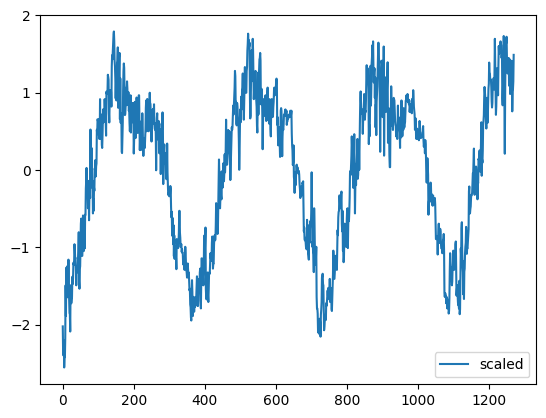

In [ ]:
# Visualize scaled data
plt.plot(train['meantemp'], label = 'scaled')
plt.legend()
plt.show()

In [ ]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])

    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['meantemp']], train['meantemp'])
X_test, y_test = create_sequences(test[['meantemp']], test['meantemp'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (1241, 30, 1)
Testing input shape:  (275, 30, 1)


In [ ]:
# set seed to regenerate same sequence of random numbers.
np.random.seed(21)
tf.random.set_seed(21)

# **Build a model**

We are building LSTM Autoencoder model. The model will take input of shape (batch_size, sequence_length, num_features) and return output of the same shape. In this case, sequence_length is 30 and num_features is 1.

In [ ]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'tanh', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_1 (RepeatVec  (None, 30, 128)           0         
 tor)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_3 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_1 (TimeDi  (None, 30, 1)             129       
 stributed)                                           

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/100
35/35 [==============================] - 20s 237ms/step - loss: 0.2647 - val_loss: 0.2800
Epoch 2/100
35/35 [==============================] - 5s 135ms/step - loss: 0.2340 - val_loss: 0.1706
Epoch 3/100
35/35 [==============================] - 3s 94ms/step - loss: 0.1855 - val_loss: 0.1656
Epoch 4/100
35/35 [==============================] - 4s 100ms/step - loss: 0.1659 - val_loss: 0.1651
Epoch 5/100
35/35 [==============================] - 5s 143ms/step - loss: 0.1681 - val_loss: 0.1594
Epoch 6/100
35/35 [==============================] - 7s 210ms/step - loss: 0.1604 - val_loss: 0.1586
Epoch 7/100
35/35 [==============================] - 8s 225ms/step - loss: 0.1609 - val_loss: 0.1584
Epoch 8/100
35/35 [==============================] - 8s 233ms/step - loss: 0.1592 - val_loss: 0.1553
Epoch 9/100
35/35 [==============================] - 7s 200ms/step - loss: 0.1680 - val_loss: 0.1502
Epoch 10/100
35/35 [==============================] - 7s 198ms/step - loss: 0.1692 - val_lo

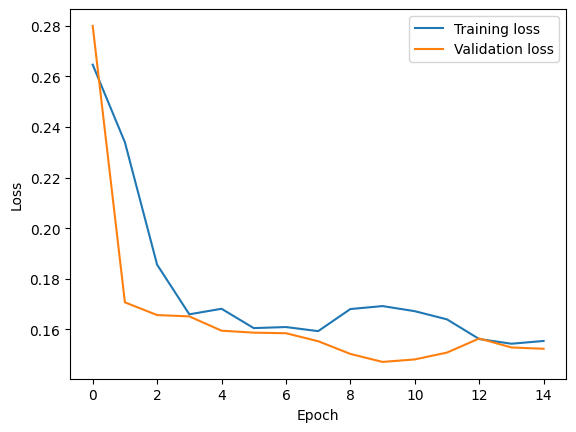

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

39/39 [==============================] - 3s 45ms/step
Reconstruction error threshold: 0.693513623432997


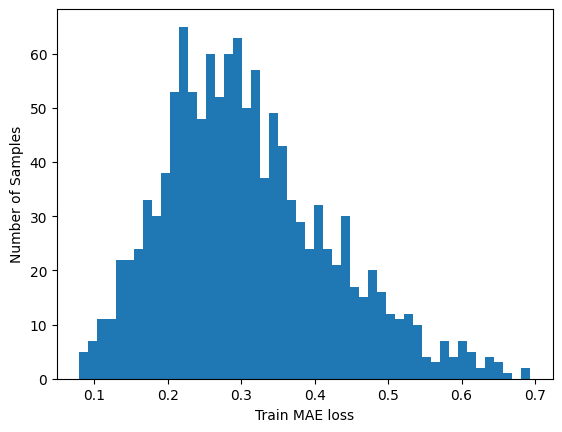

In [ ]:
# Mean Absolute Error loss
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

9/9 [==============================] - 1s 71ms/step


Text(0, 0.5, 'Number of samples')

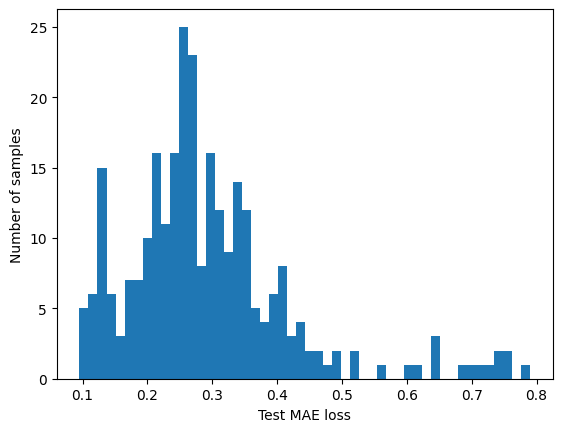

In [ ]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [ ]:
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [ ]:
anomaly_df.head()

,date,meantemp,loss,threshold,anomaly
1301,2016-07-25,0.891541,0.261366,0.693514,False
1302,2016-07-26,0.675795,0.245967,0.693514,False
1303,2016-07-27,0.410262,0.236224,0.693514,False
1304,2016-07-28,0.572348,0.253478,0.693514,False
1305,2016-07-29,0.285793,0.272932,0.693514,False


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['date'], y=anomaly_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=anomaly_df['date'], y=anomaly_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [ ]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies

,date,meantemp,loss,threshold,anomaly
87,2017-03-29,0.767072,0.708450,0.693514,True
88,2017-03-30,0.539472,0.747235,0.693514,True
89,2017-03-31,0.717284,0.738232,0.693514,True
90,2017-04-01,0.816859,0.761000,0.693514,True
91,2017-04-02,0.601114,0.790516,0.693514,True
92,2017-04-03,0.700689,0.751013,0.693514,True
93,2017-04-04,0.758221,0.723100,0.693514,True
94,2017-04-05,0.532177,0.702014,0.693514,True


In [ ]:
anomalies.shape

(8, 5)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['date'], y=anomaly_df['meantemp'], name='meantemp'))
fig.add_trace(go.Scatter(x=anomalies['date'], y=anomalies['meantemp'], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()


In [ ]:
score = model.evaluate(X_train, y_train)
score

39/39 [==============================] - 4s 103ms/step - loss: 0.1458


0.14583775401115417

In [ ]:
score = model.evaluate(X_test, y_test)
score


9/9 [==============================] - 1s 83ms/step - loss: 0.1743


0.17427945137023926